# Two metrics used for calculating how much dependence there between grid squares. We expect to see some dependence here, given that there will be some light diffusing between grid squares.

In [28]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pickle import dump
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron
from matplotlib import  rc
from matplotlib.ticker import NullFormatter
from numpy import mean, sqrt, square, arange
from itertools import combinations
rc('text', usetex=False)

In [29]:
def simpleaxis(axes, every=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [30]:
def getCentreOfMass(coords):
    centreOfMass = np.mean(coords, axis=0)
    return(centreOfMass)

def getPairwiseDistance(arr1, arr2):
    ''' This calculates the distance between two points '''
    return sqrt(mean(square(arr1 - arr2)))

In [31]:
prefix = '/home/bhalla/Documents/Codes/data'
#prefix = ''
currentClampFiles = prefix + '/media/sahil/NCBS_Shares_BGStim/patch_data/normalization_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [5]:
neurons = {}

for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = prefix + dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    if n:
        neurons[str(n.date) + '_' + str(n.index)] = n

/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/2_c1_150828/plots/2_c1_150828.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/3_c1_150929/plots/3_c1_150929.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/1_c4_150827/plots/1_c4_150827.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/6_c2_160513/plots/6_c2_160513.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/RS_TBS_short/5_c4_160122/plots/5_c4_160122.pkl not found.


In [6]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(np.linspace(0,1,len(dirnames)))

170317 c1
Control


/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


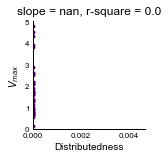

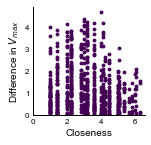

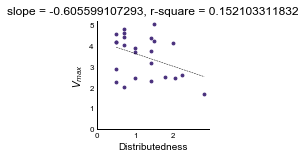

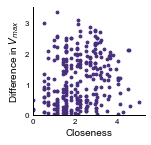

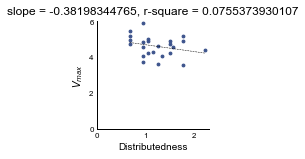

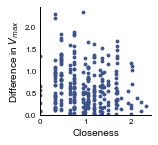

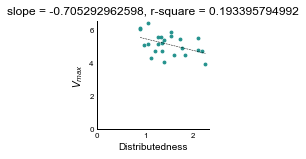

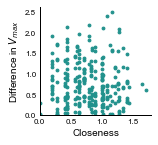

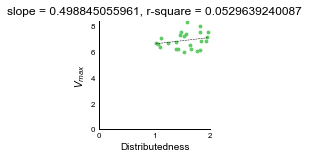

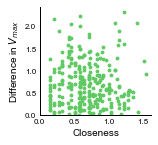

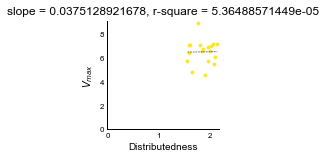

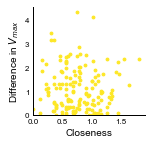

170317 c4
Control


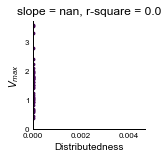

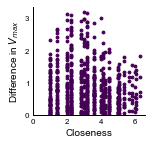

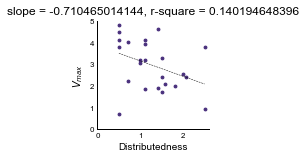

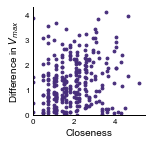

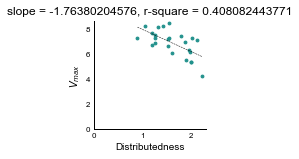

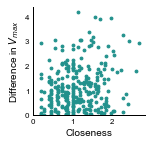

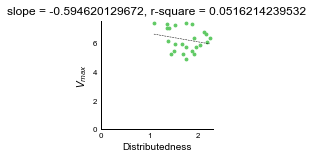

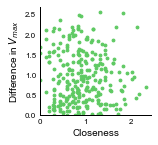

161027 c3
Control


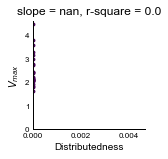

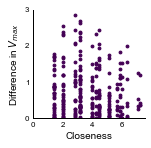

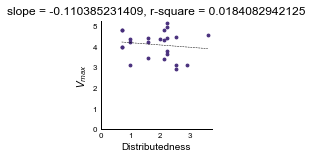

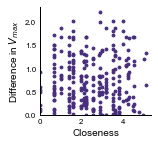

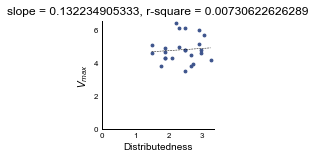

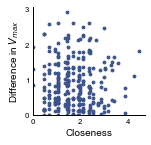

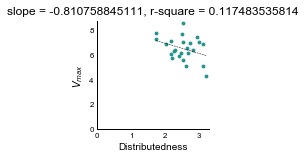

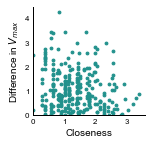

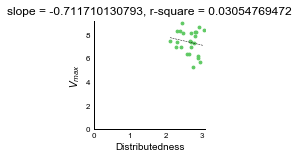

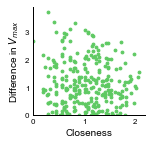

161027 c3
GABAzine


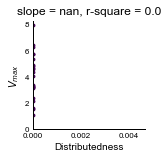

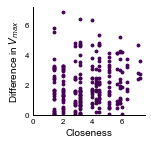

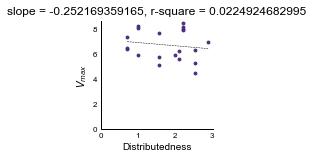

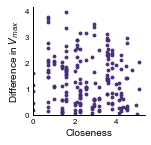

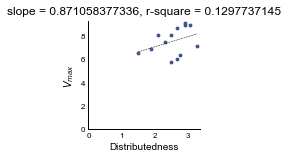

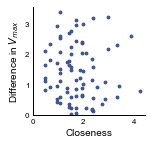

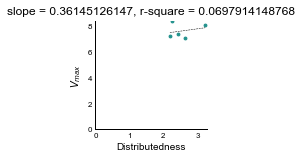

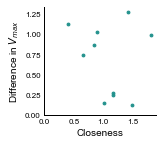

/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python2.7/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


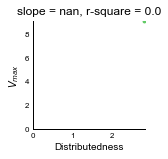

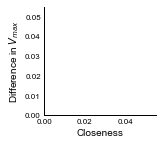

160223 c3
Control


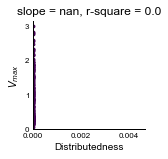

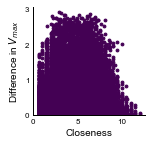

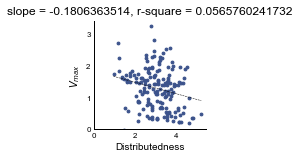

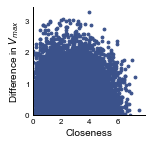

160223 c2
Control


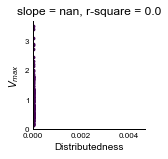

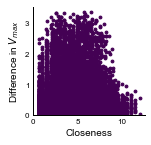

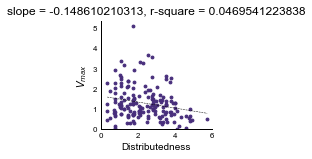

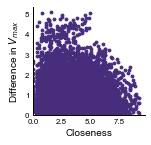

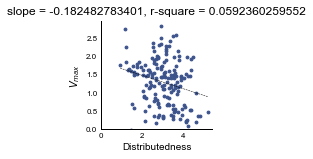

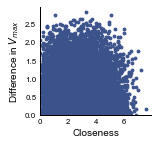

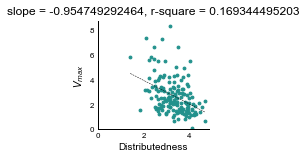

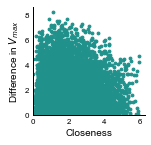

161228 c1
Control


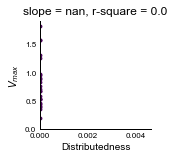

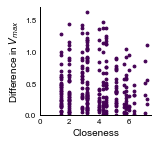

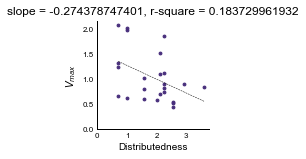

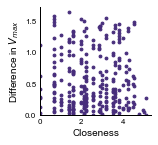

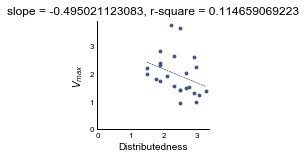

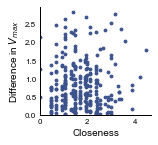

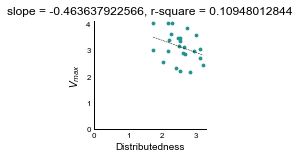

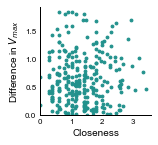

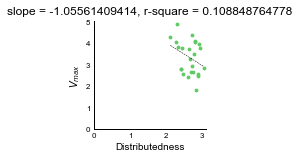

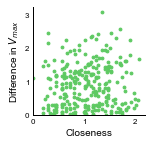

161228 c1
GABAzine


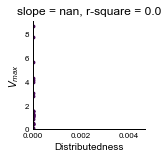

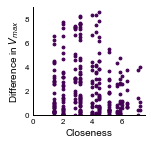

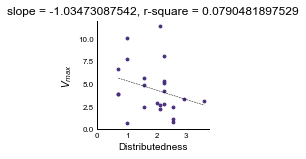

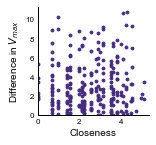

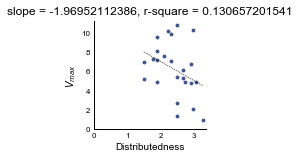

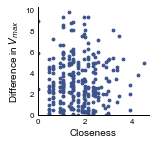

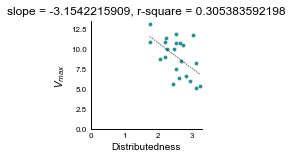

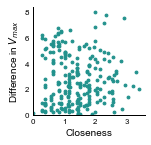

160830 c1
Control


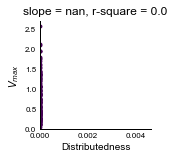

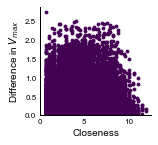

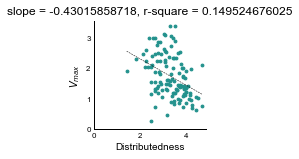

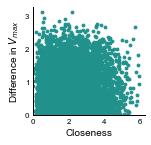

160830 c1
GABAzine


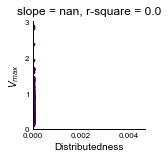

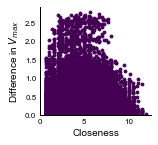

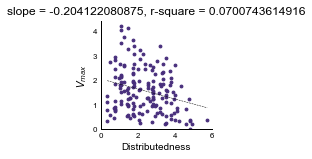

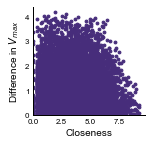

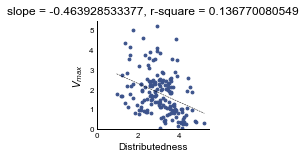

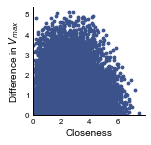

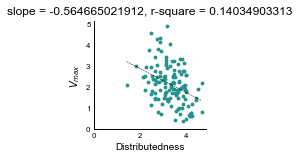

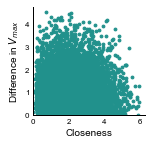

160219 c5
Control


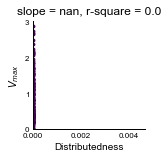

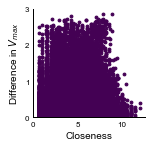

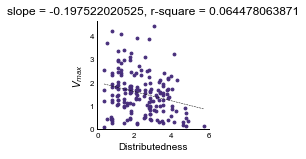

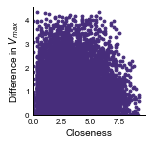

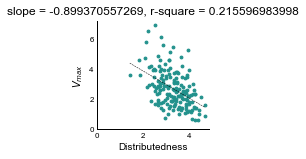

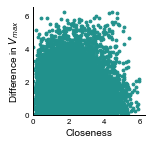

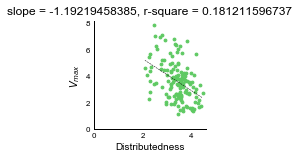

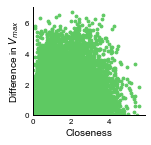

170303 c1
Control


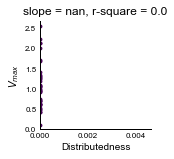

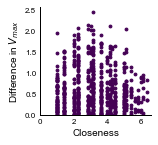

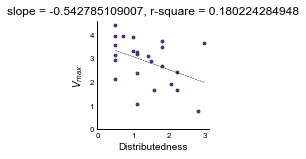

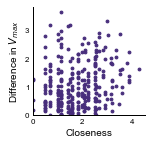

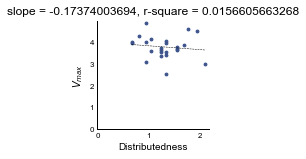

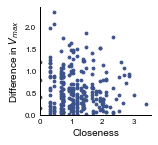

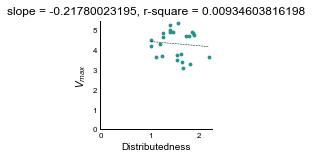

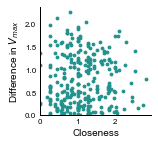

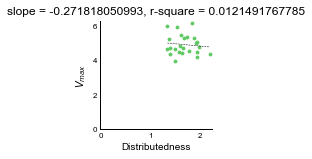

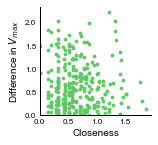

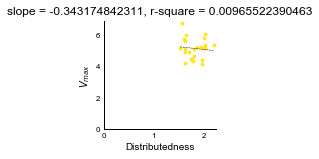

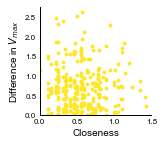

170303 c1
GABAzine


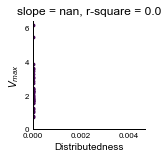

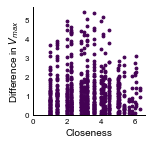

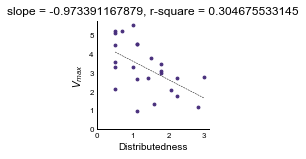

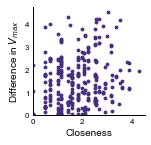

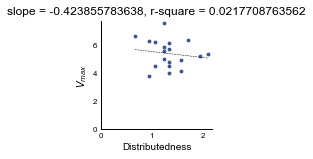

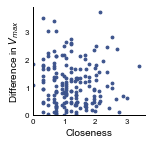

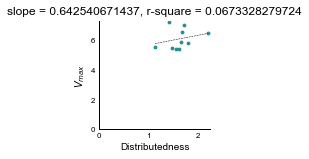

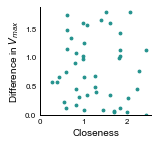

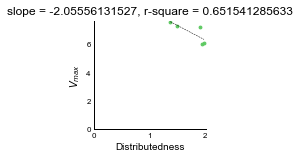

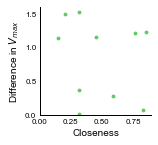

161117 c1
Control


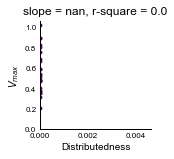

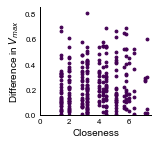

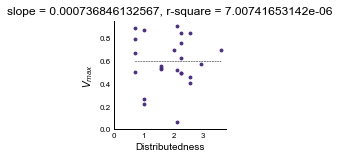

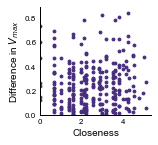

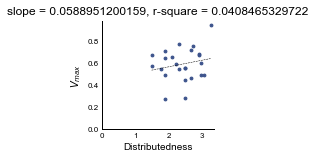

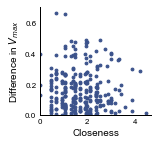

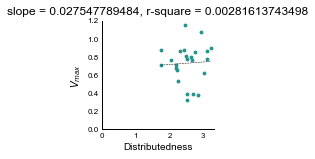

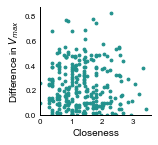

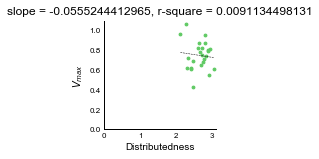

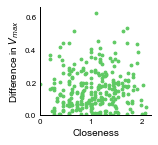

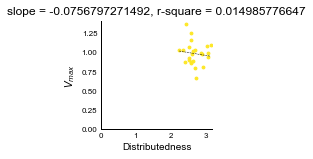

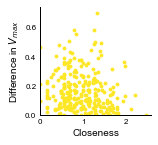

161117 c1
GABAzine


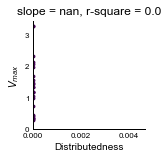

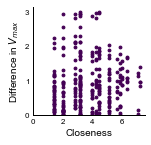

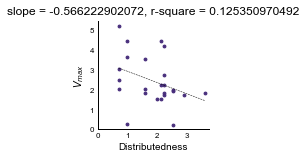

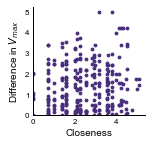

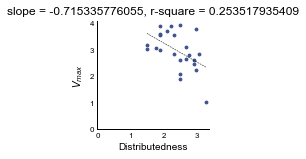

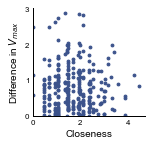

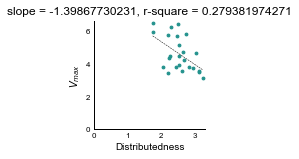

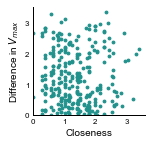

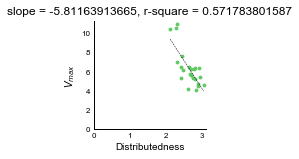

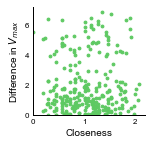

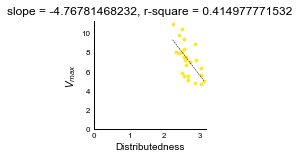

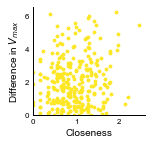

170208 c3
Control


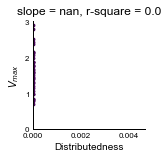

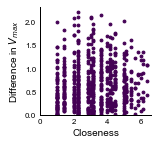

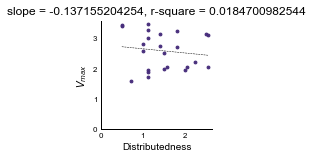

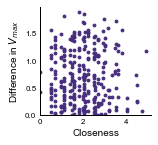

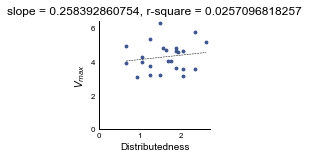

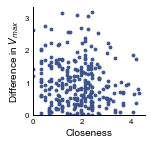

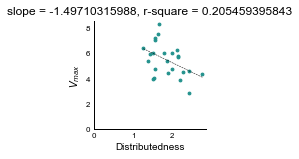

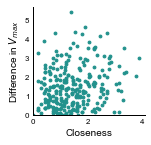

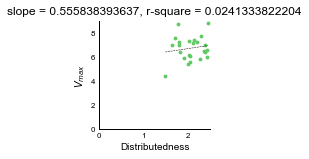

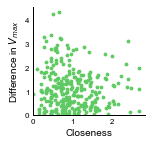

160209 c4
Control


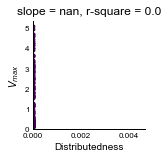

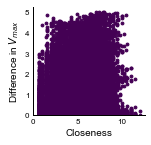

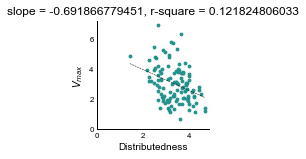

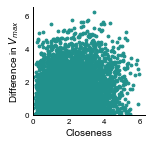

160920 c1
Control


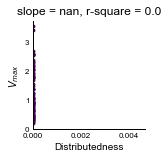

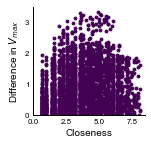

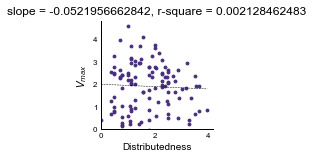

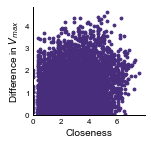

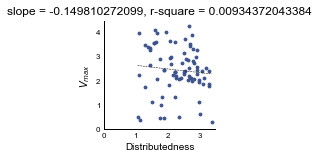

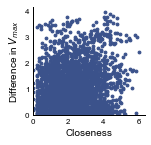

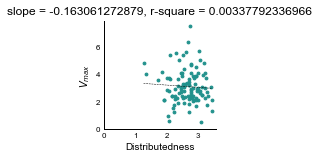

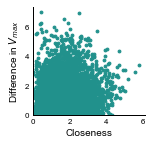

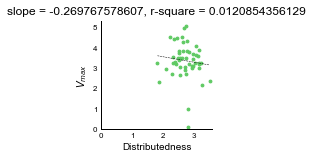

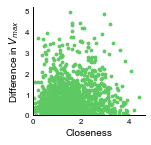

160920 c1
GABAzine


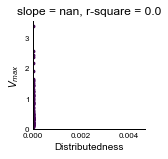

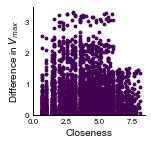

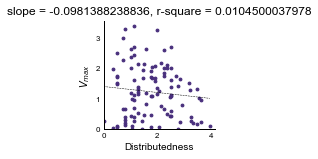

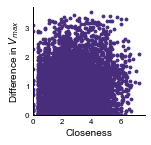

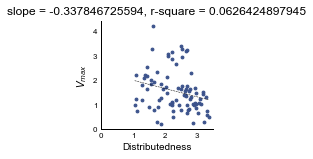

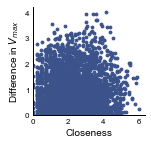

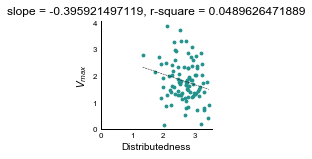

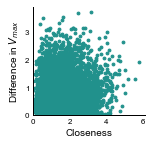

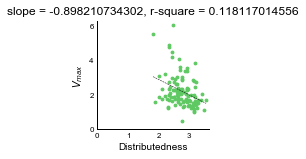

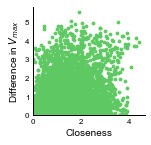

161013 c1
Control


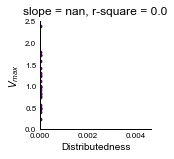

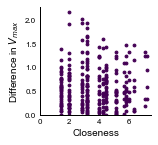

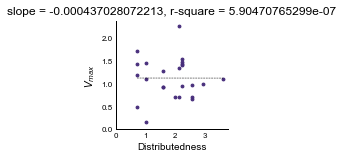

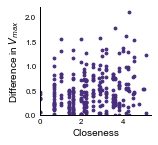

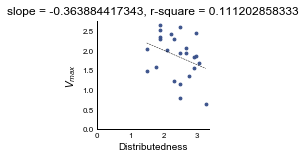

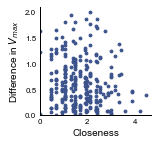

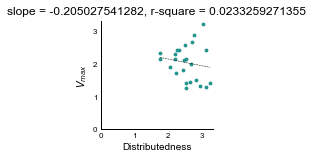

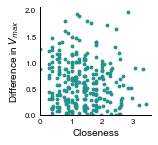

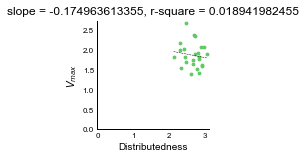

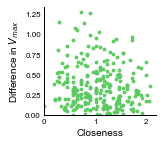

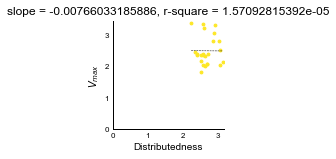

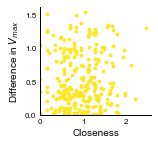

161013 c1
GABAzine


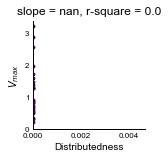

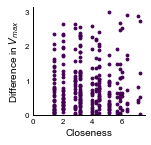

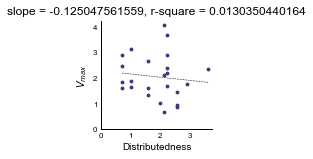

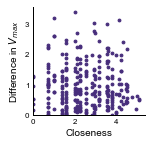

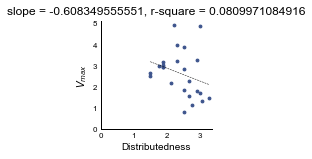

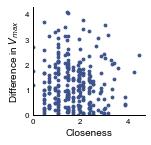

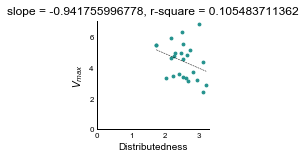

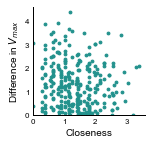

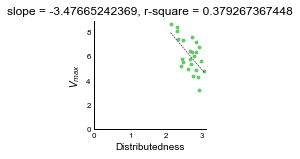

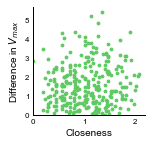

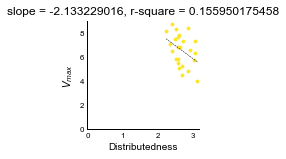

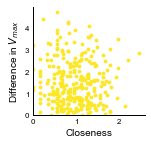

160927 c5
Control


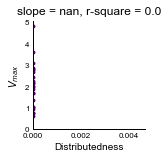

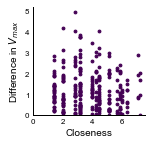

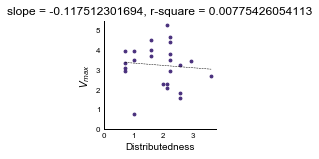

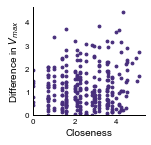

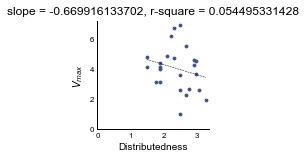

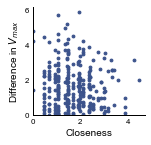

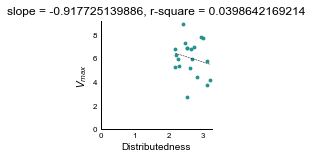

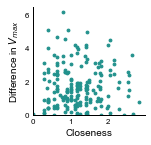

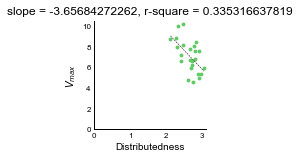

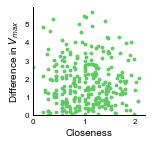

160927 c5
GABAzine


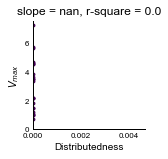

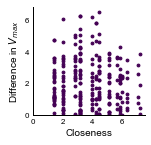

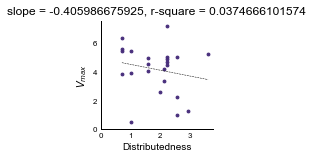

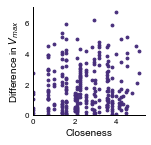

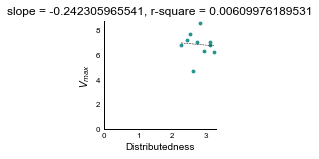

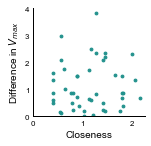

150904 c1
Control


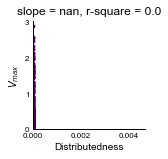

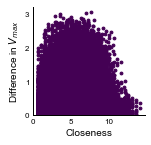

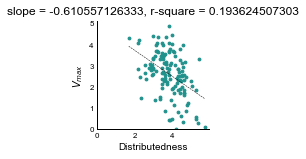

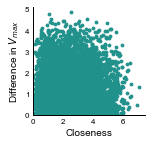

170104 c4
Control


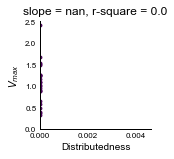

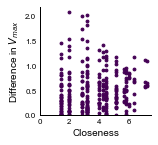

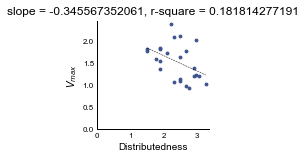

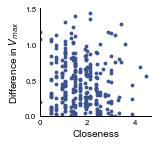

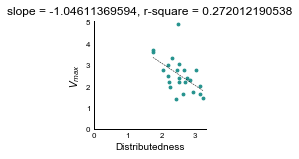

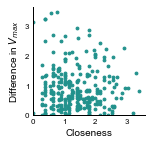

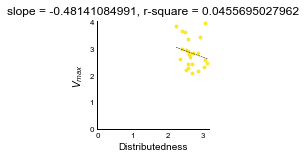

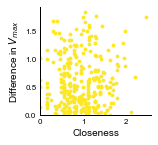

170220 c1
Control


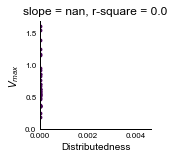

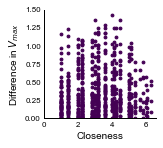

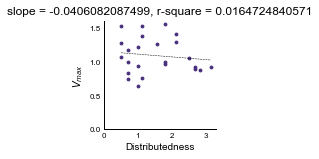

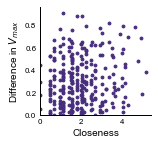

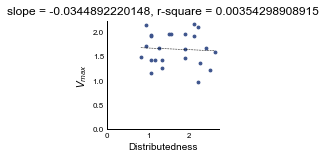

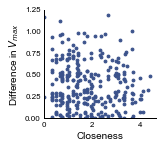

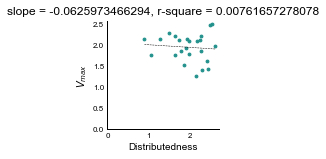

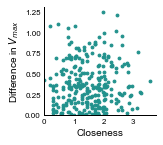

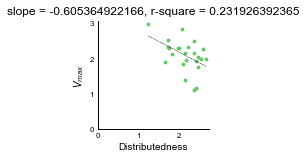

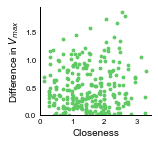

170222 c2
Control


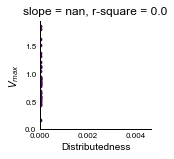

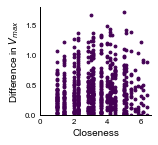

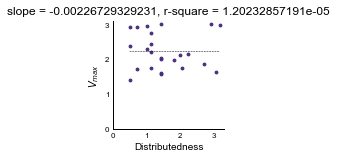

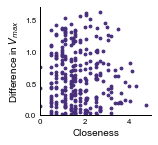

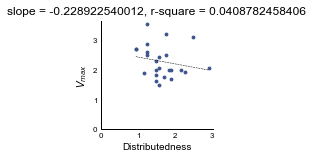

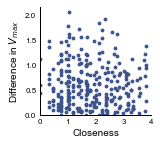

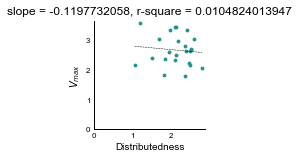

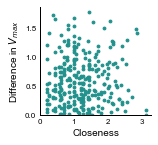

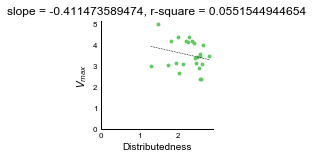

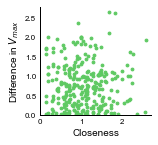

170222 c2
GABAzine


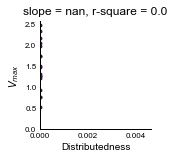

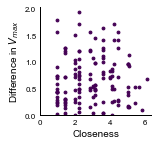

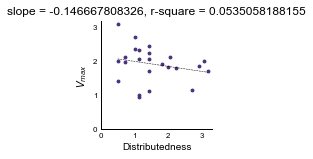

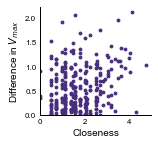

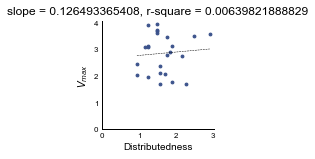

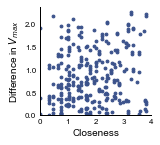

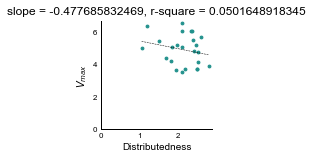

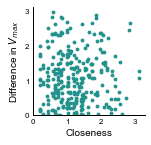

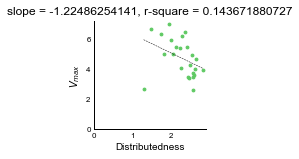

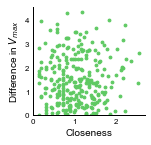

160817 c2
Control


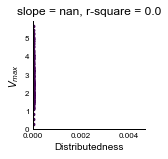

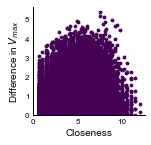

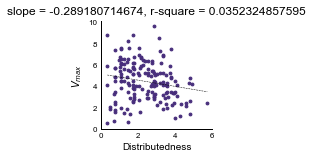

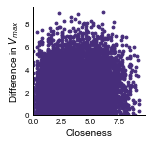

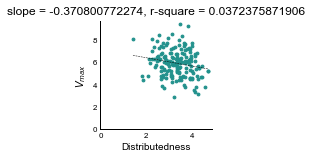

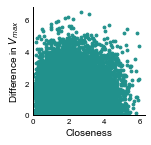

150828 c2
Control


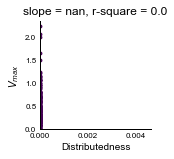

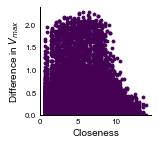

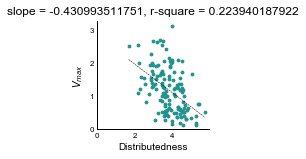

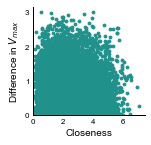

160928 c3
Control


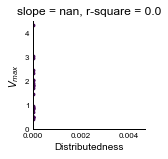

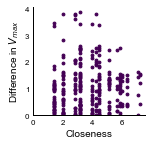

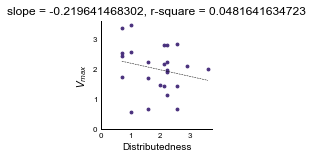

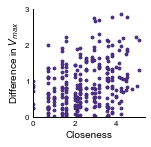

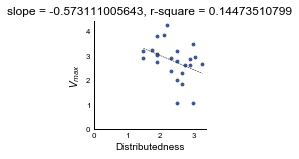

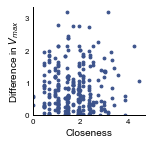

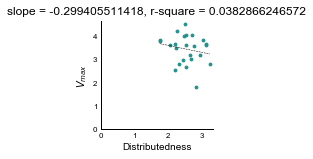

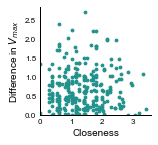

160617 c5
Control


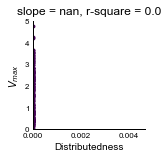

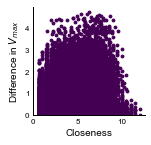

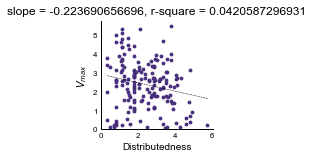

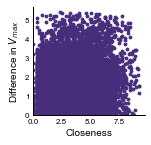

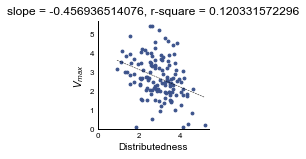

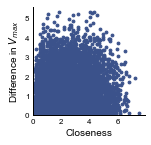

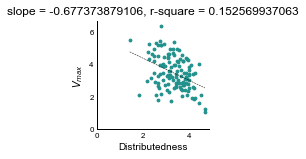

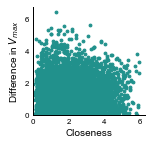

150902 c1
Control


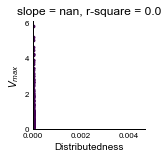

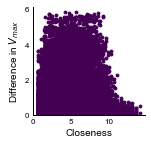

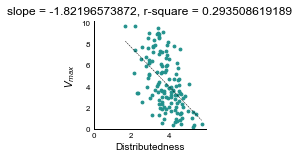

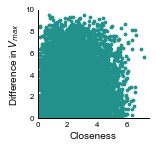

150902 c2
Control


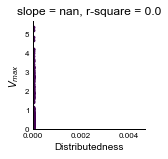

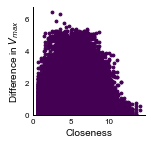

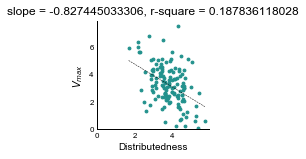

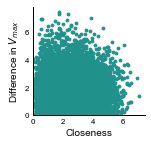

161109 c3
Control


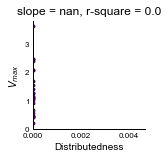

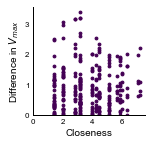

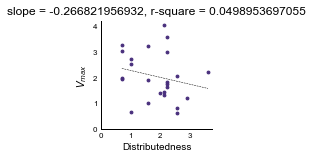

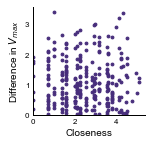

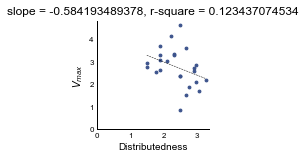

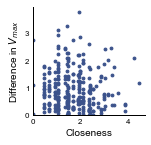

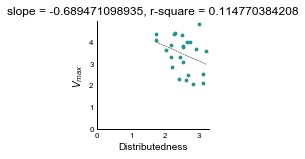

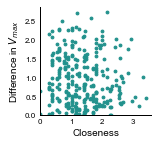

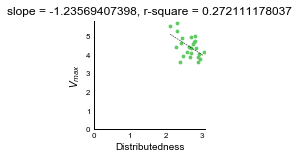

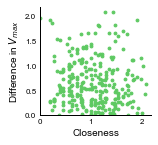

160513 c5
Control


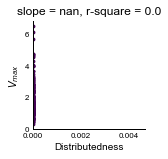

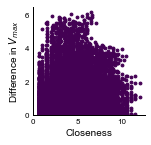

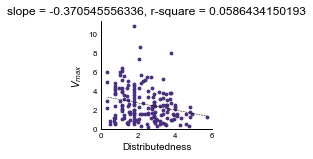

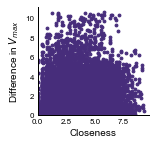

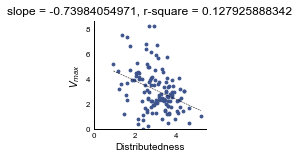

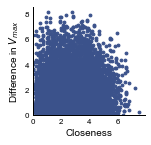

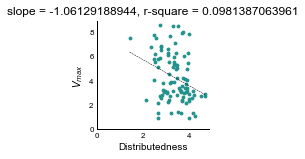

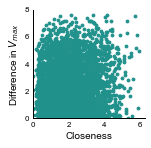

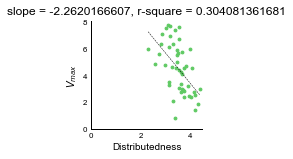

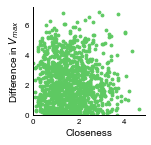

In [7]:
slopeArr, rsqrArr, gridSize, cellId, nSqr, dateArr = [], [], [], [], [], []
averageDistributedness = []
cell_num = 0
for nid, neuron in neurons.items():
    feature = 0 # Area under the curve
    expected, observed, g_expected, g_observed = {}, {}, {}, {}
    for expType, exp in neuron:
        print(neuron.date, neuron.index)
        print(expType)
        for sqr in exp:
            all_o, all_c, all_cl = [], [], []
            closeness, similarity = [], []
            for coord in exp[sqr].coordwise:
                if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                    all_o.append(exp[sqr].coordwise[coord].average_feature[feature])
                    coord = np.array(list(coord))
                    com = getCentreOfMass(coord)
#                         print(coord, com, getPairwiseDistance(coord,com))
                    all_c.append(com)
                    all_cl.append(getPairwiseDistance(coord,com))
#                     for trial in exp[sqr].coordwise[coord].trials:
#                         if all([value == 0 for value in trial.flags.values()]):
#                             print(coord)
#                             all_o.append(trial.feature[feature])
#                             all_c.append(getCentreOfMass(list(coord)))
#                             print("Distance", all_c[-1])
            # Clustering measure
            fig1, ax1 = plt.subplots()
            ax1.scatter(all_cl, all_o, s=8, c=color_sqr[sqr])
            slope,intercept,rval,pval,stderr = ss.linregress(all_cl, all_o)
            ax1.plot(np.sort(all_cl), slope*np.sort(all_cl) + intercept, '--')
            simpleaxis(ax1)
            ax1.set_title("slope = {}, r-square = {}".format(slope, rval**2))
            ax1.set_xlim(xmin=0)
            ax1.set_ylim(ymin=0)
            ax1.set_xlabel("Distributedness")
            ax1.set_ylabel("$V_{max}$")
            fig1.set_figwidth(2)
            fig1.set_figheight(2)
            plt.show()
            
            averageDistributedness.append(np.mean(all_cl))
            slopeArr.append(slope)
            rsqrArr.append(rval**2)
            cellId.append(cell_num)
            nSqr.append(sqr)
            gridSize.append(np.max([np.max(list(key)) for key in exp[1].coordwise.keys()]))
            dateArr.append(neuron.date)
            
            
            # Closeness measure
            for index in combinations(range(len(all_c)), 2):
                closeness.append(getPairwiseDistance(all_c[index[0]], all_c[index[1]]))
                similarity.append(getPairwiseDistance(all_o[index[0]], all_o[index[1]]))
            fig, ax = plt.subplots()
            ax.scatter(closeness, similarity, s=8, c=color_sqr[sqr])
            ax.set_xlim(xmin=0)
            ax.set_ylim(ymin=0)
            ax.set_xlabel("Closeness")
            ax.set_ylabel("Difference in $V_{max}$")
            simpleaxis(ax)
            fig.set_figwidth(2)
            fig.set_figheight(2)
            plt.show(fig)
    cell_num+=1

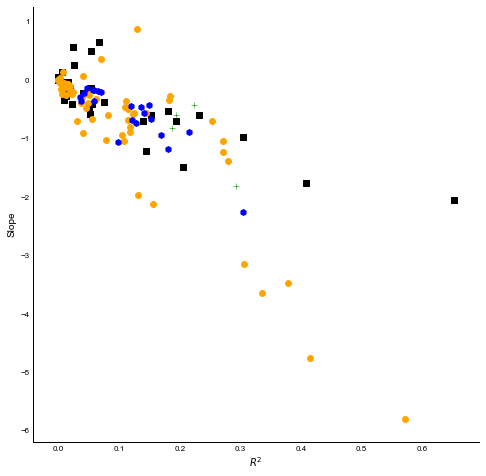

In [8]:
gridSize, rsqrArr, slopeArr, nSqr, cellId, dateArr = np.array(gridSize), np.array(rsqrArr), np.array(slopeArr), np.array(nSqr), np.array(cellId), np.array(dateArr)
markers = {10:'s', 11:'o', 12:'h', 14:'+'}
colors = {10:'k', 11:'orange', 12:'blue', 14:'green'}

fig, ax = plt.subplots()
for k, m in markers.items():
    i = (gridSize == k)
    scat = ax.scatter(rsqrArr[i], slopeArr[i], marker = m, s=35, color=colors[k])
simpleaxis(ax)
ax.set_xlabel("$R^2$")
ax.set_ylabel("Slope")
fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

# Plotting the relationship of the Rsquares with slope
## Dotted lines represent medians of the distributions

In [9]:
# definitions for the axes

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.1

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

xlims = (0., 1)
ylims = (-6,1)

histx_xlim = xlims
histy_ylim = ylims

nbins = 30
bins_rsqrArr = np.linspace( np.nanmin(rsqrArr), np.nanmax(rsqrArr), nbins)
bins_slopeArr = np.linspace( np.nanmin(slopeArr), np.nanmax(slopeArr), nbins)

## Not colored

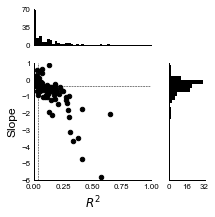

In [10]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

nullfmt   = NullFormatter()         # no labels

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# now determine nice limits by hand:

axScatter.set_xlim( xlims )
axScatter.set_ylim( ylims )
axScatter.set_xlabel("$R^2$", fontsize='large')
axScatter.set_ylabel("Slope", fontsize='large')

for k, c in colors.items():
    i = (gridSize == k)
    scat = axScatter.scatter(rsqrArr[i], slopeArr[i], marker = 'o', s=20, color='k')

axScatter.hlines(y=np.nanmedian(slopeArr), xmin=xlims[0], xmax=xlims[1], color='k', linestyles='--')
axScatter.vlines(x=np.nanmedian(rsqrArr), ymin=ylims[0], ymax=ylims[1], color='k', linestyles='--')

axScatter.ticklabel_format(style='sci',scilimits=(-2,2),axis='both')

axHistx.hist(rsqrArr, bins=bins_rsqrArr, color='k')
axHisty.hist(slopeArr[~np.isnan(slopeArr)], bins=bins_slopeArr, color='k', orientation='horizontal')

axHistx.set_xlim( histx_xlim )
axHisty.set_ylim( histy_ylim )

#axHisty.tick_params(axis = 'y', bottom='off')
start, end = axHistx.get_ylim()
axHistx.yaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))
start, end = axHisty.get_xlim()
axHisty.xaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))

simpleaxis([axScatter, axHistx, axHisty])
fig.set_figwidth(2.5)
fig.set_figheight(2.5)
plt.show()

In [26]:
float(len(rsqrArr[rsqrArr < 0.2]))/ len(rsqrArr)

0.8823529411764706

## Each gridsize is colored differently 

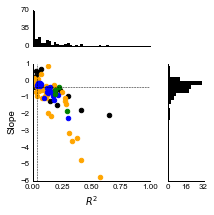

In [406]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

nullfmt   = NullFormatter()         # no labels

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# now determine nice limits by hand:

axScatter.set_xlim( xlims )
axScatter.set_ylim( ylims )
axScatter.set_xlabel("$R^2$", fontsize='large')
axScatter.set_ylabel("Slope", fontsize='large')

for k, c in colors.items():
    i = (gridSize == k)
    scat = axScatter.scatter(rsqrArr[i], slopeArr[i], marker = 'o', s=20, color=c)

axScatter.hlines(y=np.nanmedian(slopeArr), xmin=xlims[0], xmax=xlims[1], color='k', linestyles='--')
axScatter.vlines(x=np.nanmedian(rsqrArr), ymin=ylims[0], ymax=ylims[1], color='k', linestyles='--')

axScatter.ticklabel_format(style='sci',scilimits=(-2,2),axis='both')

axHistx.hist(rsqrArr, bins=bins_rsqrArr, color='k')
axHisty.hist(slopeArr[~np.isnan(slopeArr)], bins=bins_slopeArr, color='k', orientation='horizontal')

axHistx.set_xlim( histx_xlim )
axHisty.set_ylim( histy_ylim )

#axHisty.tick_params(axis = 'y', bottom='off')
start, end = axHistx.get_ylim()
axHistx.yaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))
start, end = axHisty.get_xlim()
axHisty.xaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))

simpleaxis([axScatter, axHistx, axHisty])
fig.set_figwidth(2.5)
fig.set_figheight(2.5)
plt.show()

## Each cell is colored differently

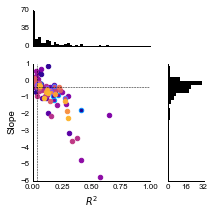

In [407]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

nullfmt   = NullFormatter()         # no labels

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# now determine nice limits by hand:

axScatter.set_xlim( xlims )
axScatter.set_ylim( ylims )
axScatter.set_xlabel("$R^2$", fontsize='large')
axScatter.set_ylabel("Slope", fontsize='large')

for k, c in enumerate(color_cell):
    i = (cellId == k)
    scat = axScatter.scatter(rsqrArr[i], slopeArr[i], marker = 'o', s=20, color=c)

axScatter.hlines(y=np.nanmedian(slopeArr), xmin=xlims[0], xmax=xlims[1], color='k', linestyles='--')
axScatter.vlines(x=np.nanmedian(rsqrArr), ymin=ylims[0], ymax=ylims[1], color='k', linestyles='--')

axScatter.ticklabel_format(style='sci',scilimits=(-2,2),axis='both')

axHistx.hist(rsqrArr, bins=bins_rsqrArr, color='k')
axHisty.hist(slopeArr[~np.isnan(slopeArr)], bins=bins_slopeArr, color='k', orientation='horizontal')

axHistx.set_xlim( histx_xlim )
axHisty.set_ylim( histy_ylim )

#axHisty.tick_params(axis = 'y', bottom='off')
start, end = axHistx.get_ylim()
axHistx.yaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))
start, end = axHisty.get_xlim()
axHisty.xaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))

simpleaxis([axScatter, axHistx, axHisty])
fig.set_figwidth(2.5)
fig.set_figheight(2.5)
plt.show()

## Looking at the variability across the different number of squares

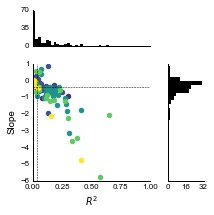

In [408]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

nullfmt   = NullFormatter()         # no labels

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# now determine nice limits by hand:

axScatter.set_xlim( xlims )
axScatter.set_ylim( ylims )
axScatter.set_xlabel("$R^2$", fontsize='large')
axScatter.set_ylabel("Slope", fontsize='large')

for k, c in color_sqr.items():
    i = ( nSqr == k)
    scat = axScatter.scatter(rsqrArr[i], slopeArr[i], marker = 'o', s=20, color=c)

axScatter.hlines(y=np.nanmedian(slopeArr), xmin=xlims[0], xmax=xlims[1], color='k', linestyles='--')
axScatter.vlines(x=np.nanmedian(rsqrArr), ymin=ylims[0], ymax=ylims[1], color='k', linestyles='--')

axScatter.ticklabel_format(style='sci',scilimits=(-2,2),axis='both')

axHistx.hist(rsqrArr, bins=bins_rsqrArr, color='k')
axHisty.hist(slopeArr[~np.isnan(slopeArr)], bins=bins_slopeArr, color='k', orientation='horizontal')

axHistx.set_xlim( histx_xlim )
axHisty.set_ylim( histy_ylim )

#axHisty.tick_params(axis = 'y', bottom='off')
start, end = axHistx.get_ylim()
axHistx.yaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))
start, end = axHisty.get_xlim()
axHisty.xaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))

simpleaxis([axScatter, axHistx, axHisty])
fig.set_figwidth(2.5)
fig.set_figheight(2.5)
plt.show()

## Colored by date

In [409]:
dateSet = np.array(sorted(list(set(dateArr))))
color_date =  matplotlib.cm.viridis(np.linspace(0,1,len(dateSet)))    

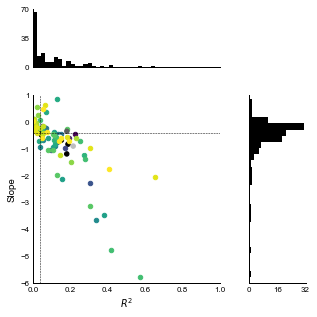

In [410]:
# start with a rectangular Figure
fig = plt.figure(1, figsize=(8,8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

nullfmt   = NullFormatter()         # no labels

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# now determine nice limits by hand:

axScatter.set_xlim( xlims )
axScatter.set_ylim( ylims )
axScatter.set_xlabel("$R^2$", fontsize='large')
axScatter.set_ylabel("Slope", fontsize='large')

for k, c in enumerate(dateSet):
    i = ( dateArr == c)
    scat = axScatter.scatter(rsqrArr[i], slopeArr[i], marker = 'o', s=20, c=color_date[k])

axScatter.hlines(y=np.nanmedian(slopeArr), xmin=xlims[0], xmax=xlims[1], color='k', linestyles='--')
axScatter.vlines(x=np.nanmedian(rsqrArr), ymin=ylims[0], ymax=ylims[1], color='k', linestyles='--')

axScatter.ticklabel_format(style='sci',scilimits=(-2,2),axis='both')

axHistx.hist(rsqrArr, bins=bins_rsqrArr, color='k')
axHisty.hist(slopeArr[~np.isnan(slopeArr)], bins=bins_slopeArr, color='k', orientation='horizontal')

axHistx.set_xlim( histx_xlim )
axHisty.set_ylim( histy_ylim )

#axHisty.tick_params(axis = 'y', bottom='off')
start, end = axHistx.get_ylim()
axHistx.yaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))
start, end = axHisty.get_xlim()
axHisty.xaxis.set_ticks(np.arange(int(start), int(end+1.), int(end/2)))

simpleaxis([axScatter, axHistx, axHisty])
fig.set_figwidth(4)
fig.set_figheight(4)
plt.show()

In [413]:
i = (rsqrArr>0.4)
set(sorted(dateArr[i]))
# sorted(dateArr[j])

{'161117', '170303', '170317'}

In [412]:
set(dateArr)

{'150828',
 '150902',
 '150904',
 '160209',
 '160219',
 '160223',
 '160513',
 '160617',
 '160817',
 '160830',
 '160920',
 '160927',
 '160928',
 '161013',
 '161027',
 '161109',
 '161117',
 '161228',
 '170104',
 '170208',
 '170220',
 '170222',
 '170303',
 '170317'}

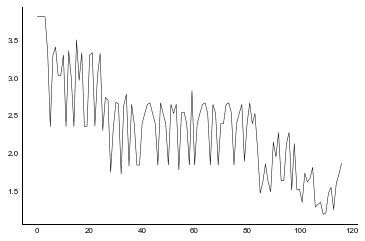

In [399]:
averageDistributedness = np.array(averageDistributedness)
indices = np.argsort(dateArr)
fig, ax = plt.subplots()
newIndices = (averageDistributedness[indices]!=0)
ax.plot(averageDistributedness[indices][newIndices])
ax.set_xlabel("Date")
ax.set_ylabel("Average distributedness")
simpleaxis(ax)
plt.show()